!pip3.10 install --upgrade pip
!pip3.10 install --upgrade transformers scipy diffusers
!pip3.10 install --upgrade moviepy ffmpeg 

In [2]:
import torch

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
device

device(type='mps')

In [5]:
torch.set_printoptions(profile="full")
torch.backends.mps.verbose = True

In [1]:
from transformers import pipeline
import scipy

#synthesiser = pipeline("text-to-audio", "facebook/musicgen-small", device=device)
synthesiser = pipeline("text-to-audio", "facebook/musicgen-small")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/encodec/modeling_encodec.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [2]:
music = synthesiser("a little girl with her hands up and a flower in her mouth.", forward_params={"do_sample": True,  "max_length": 200 })

`torch.nn.functional.scaled_dot_product_attention` does not support having an empty attention mask. Falling back to the manual attention implementation. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.Note that this probably happens because `guidance_scale>1` or because you used `get_unconditional_inputs`. See https://github.com/huggingface/transformers/issues/31189 for more information.


In [3]:
scipy.io.wavfile.write("nb_musicgen_out.wav", rate=music["sampling_rate"], data=music["audio"])

In [10]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration
import scipy

processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [11]:
inputs = processor(
    text=["a little girl with her hands up and a flower in her mouth.", "90s rock song with loud guitars and heavy drums"],
    padding=True,
    return_tensors="pt",
)

audio_values = model.generate(**inputs, max_new_tokens=256)

In [16]:
# Assuming the model returns the generated audio as a tensor
# Convert the generated tensor into a numpy array for saving
audio_data = audio_values.cpu().detach().numpy()
#audio_data = audio_values[0].numpy()

# Set the sampling rate (this should match the rate expected by the model output)
sampling_rate = 44100  # This is an example, adjust based on the model's output specification

# Save the audio data to a WAV file
scipy.io.wavfile.write("this_is_a_lot.wav", rate=model.config.audio_encoder.sampling_rate, data=audio_data)

In [17]:
from IPython.display import Audio

sampling_rate = model.config.audio_encoder.sampling_rate
Audio(audio_values[0].numpy(), rate=sampling_rate)

In [18]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

model_id = "stabilityai/stable-diffusion-2"
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
pipe = pipe.to("mps")

prompt = "album cover: a little girl with her hands up and a flower in her mouth."
image = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

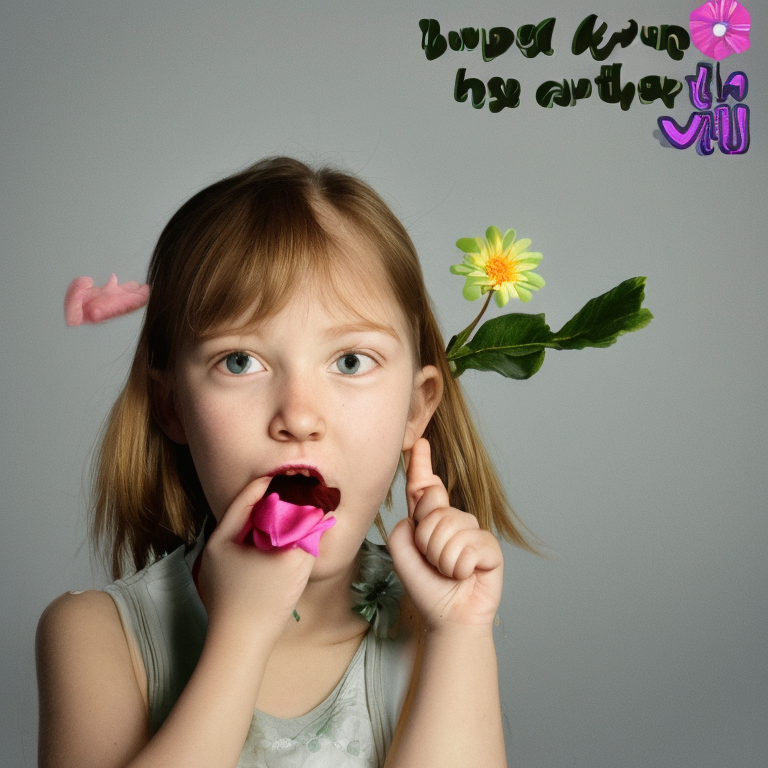

In [20]:
image

In [21]:
image.save("output.png")

In [6]:
from moviepy.editor import *

# Define the paths to your image and audio files
image_path = "output.png"  # Path to your PNG image
audio_path = "musicgen_out.wav"  # Path to your WAV audio
output_video_path = "final_video.mp4"  # Path to save the output video

# Load the audio file
audio_clip = AudioFileClip(audio_path)

# Load the image and set the duration to match the audio file's duration
image_clip = ImageClip(image_path).set_duration(audio_clip.duration)

# Explicitly set the frame rate (FPS) for the video
fps = 24  # Use a common frame rate
image_clip = image_clip.set_fps(fps)

# Print the fps to debug
print(f"FPS value: {fps}")

# Check if fps is set correctly
if fps is None:
    raise ValueError("FPS value is None. Please set a valid FPS.")

# Set the audio to the image clip
video_clip = image_clip.set_audio(audio_clip)

# Write the video file
video_clip.write_videofile(
    output_video_path, 
    codec="libx264", 
    audio_codec="aac", 
    fps=fps  # Pass the fps explicitly
)

FPS value: 24
Moviepy - Building video final_video.mp4.
MoviePy - Writing audio in final_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video final_video.mp4



Moviepy - Done !
Moviepy - video ready final_video.mp4


In [30]:
image_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac", fps=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Moviepy - Building video final_video.mp4.
MoviePy - Writing audio in final_videoTEMP_MPY_wvf_snd.mp3


chunk:   0%|                                  | 0/660 [00:00<?, ?it/s, now=None]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
                                                                                

MoviePy - Done.
Moviepy - Writing video final_video.mp4



TypeError: must be real number, not NoneType

In [31]:
!ffmpeg -loop 1 -i output.png -i musicgen_out.wav -c:v libx264 -tune stillimage -c:a aac -b:a 192k -pix_fmt yuv420p -shortest output_video.mp4

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[out#0/mp4 @ 0x600000658000] video:782KiB audio:455KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.992591%
frame=  799 fps=460 q=-1.0 Lsize=    1262KiB time=00:00:29.92 bitrate= 345.4kbits/s speed=17.2x    
[libx264 @ 0x1600053a0] frame I:4     Avg QP:13.79  size:148416
[libx264 @ 0x1600053a0] frame P:201   Avg QP:15.09  size:   847
[libx264 @ 0x1600053a0] frame B:594   Avg QP:22.33  size:    60
[libx264 @ 0x1600053a0] consecutive B-frames:  0.9%  0.0%  0.0% 99.1%
[libx264 @ 0x1600053a0] mb I  I16..4: 16.3% 41.1% 42.6%
[libx264 @ 0x1600053a0] mb P  I16..4:  0.0%  0.1%  0.0%  P16..4:  2.1%  0.1%  0.2%  0.0%  0.0%    skip:97.6%
[libx264 @ 0x1600053a0] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  1.5%  0.0%  0.0%  direct: 0.0%  skip:98.5%  L0:56.2% L1:43.4% BI: 0.5%
[libx264 @ 0x1600053a0] 8x8 transform intra:42.6% inter:89.4%
[libx264 @ 0x1600053a0] coded y,uvDC,uvAC intra: 99.1% 95.5% 91.2% inter: 0.3% 0.1% 0.0%
[libx264 @ 0x1600053a0] i16 v,h,dc,p:  2%  1% 55% 